In [ ]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import harmonypy as hm

### Step 1: Load the Preprocessed Lung Dataset
We load epithelial cells from a publicly available human lung scRNA-seq dataset (`.h5ad` format).


In [ ]:

adata_lung = sc.read_h5ad("data/normal/LUNG_HCA_filtered_epithelial_10x_240225.h5ad")
adata_lung.obs["dataset"] = "LUNG_HCA_filtered_epithelial"

### Step 2: Inspect Expression Value Range
Check the minimum and maximum values in the expression matrix to evaluate whether the data are log-normalized.

To determine the normalization method used in the dataset, we begin by examining the range of expression values. This helps to confirm whether the matrix is log-transformed. If the values are small and span a compressed range, they are likely log-transformed. We will later assess total expression per cell to infer the scaling method (e.g., per 10,000 or 1,000,000 counts).
Check the minimum and maximum values in the expression matrix to evaluate whether the data are log-normalized.


In [ ]:
print(adata_lung.X.min(), adata_lung.X.max())

0.0 11.255894


In [21]:
# Структура датасета
adata_lung

AnnData object with n_obs × n_vars = 282295 × 27957
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', '

### Step 3: Reverse Log Transformation and Assess Normalization
Undo the `log1p` transformation using `expm1`, calculate total expression per cell, and plot the distribution to understand the normalization scale (e.g., per 10,000 or per 1,000,000).

The expression matrix appears to be both normalized and log-transformed. We hypothesize the data are normalized to 10,000 counts per cell.

**Interpretation guidelines:**
- If the data were log-transformed with `log1p`, use `np.expm1(adata.X)` to revert.
- If the total expression per cell is approximately 10,000, the normalization method is likely TP10K (transcripts per 10,000).
- If the sum is closer to 1,000,000, it suggests CPM (counts per million) normalization.
- If the distribution is highly variable, normalization might not have been applied consistently.

By plotting the total counts per cell, we can visually assess which normalization method was likely used.
Undo the `log1p` transformation using `expm1`, calculate total expression per cell, and plot the distribution to understand the normalization scale (e.g., per 10,000 or per 1,000,000).


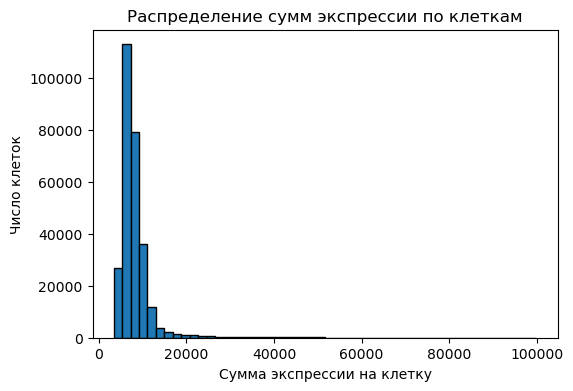

Медиана суммы по клеткам: [[ 5823.9175  6168.3853  6703.1274 ...  9563.848   9531.713  99914.01  ]]
Среднее значение суммы: 8313.560546875
Минимальная сумма: 3374.605224609375, максимальная: 99914.0078125


In [ ]:
adata_lung_copy = adata_lung.copy()
adata_lung_copy.X = np.expm1(adata_lung_copy.X)
cell_sums = adata_lung_copy.X.sum(axis=1)

plt.figure(figsize=(6,4))
plt.hist(cell_sums, bins=50, edgecolor='black')
plt.xlabel("Total expression per cell")
plt.ylabel("Number of cells")
plt.title("Distribution of total expression per cell")
plt.show()

print(f"Median: {np.median(cell_sums)}")
print(f"Mean: {np.mean(cell_sums)}")
print(f"Min: {cell_sums.min()}, Max: {cell_sums.max()}")

### Step 4: Metadata standartization
To ensure consistent formatting with other datasets, we standardize the `adata.var` table:
- Set the gene names as the index using the `feature_name` column.
- Remove all additional columns, keeping only the gene index.

This step is crucial for downstream integration with other datasets that follow the same schema.
Retain only gene identifiers as the index in `adata.var`, removing all other columns to ensure compatibility with other datasets.

In [ ]:
adata_lung.var.head()

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type
ENSG00000000003,False,TSPAN6,NCBITaxon:9606,gene,2396,protein_coding
ENSG00000000005,False,TNMD,NCBITaxon:9606,gene,873,protein_coding
ENSG00000000419,False,DPM1,NCBITaxon:9606,gene,1262,protein_coding
ENSG00000000457,False,SCYL3,NCBITaxon:9606,gene,2916,protein_coding
ENSG00000000460,False,C1orf112,NCBITaxon:9606,gene,2661,protein_coding


In [ ]:
adata_lung.var.index = adata_lung.var["feature_name"]

adata_lung.var = adata_lung.var[[]]

/home/patskanivan/miniconda3/envs/scrna/lib/python3.12/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [70]:
adata_lung.var

""
feature_name
TSPAN6
TNMD
DPM1
SCYL3
C1orf112
...
ENSG00000283078.1
ENSG00000283103.5
MGC4859


### Step 5: Inspect and Select Relevant Cell Metadata
To harmonize this dataset with others, we retain a core set of metadata fields:
- `donor_id`: identifies individual donors
- `cell_type`: assigned cell identity
- `study`: used as a batch indicator in some datasets

We also inspect values in the `disease`, `sample`, and `study` columns to verify the dataset contains only healthy samples and to estimate sample/batch structure.
Review metadata fields and retain only those required for downstream integration: `donor_id`, `cell_type`, and `study`.

In [71]:
adata_lung.obs[["log10_total_counts", "sample", 'study', 'tissue_type', 'cell_type', 'tissue', 'development_stage', 'disease']]

,log10_total_counts,sample,study,tissue_type,cell_type,tissue,development_stage,disease
GCTCTGTAGTGCTGCC_SC27,3.493458,SC27,Misharin_Budinger_2018,tissue,pulmonary alveolar type 2 cell,lung parenchyma,47-year-old stage,normal
CTTGATTGTCAGTTTG_T164,4.733551,T164,Seibold_2020,tissue,respiratory basal cell,respiratory airway,66-year-old stage,normal
P3_3_CCACTACTCATTGCGA,3.871865,proximal 3,Krasnow_2020,tissue,respiratory basal cell,respiratory airway,51-year-old stage,normal
GGGAAGTAGCAGCGAT_T165,4.451587,T165,Seibold_2020,tissue,respiratory basal cell,respiratory airway,64-year-old stage,normal
TAAGTGCCACTGTTAG_T121,4.154850,T121,Seibold_2020,tissue,respiratory basal cell,respiratory airway,23-year-old stage,normal
...,...,...,...,...,...,...,...,...
TTCTACACATACTACG_T85,4.052925,T85,Seibold_2020,tissue,respiratory hillock cell,respiratory airway,59-year-old stage,normal
ACCTTTACATTAACCG_T120,4.184152,T120,Seibold_2020,tissue,respiratory basal cell,respiratory airway,57-year-old stage,normal
AGGCCGTGTGTGACCC-SC56,4.076422,SC56,Lafyatis_Rojas_2019,tissue,pulmonary alveolar type 2 cell,lung parenchyma,57-year-old stage,normal
CGATGGCAGCAGGCTA-1-2,3.653309,SC174_SC173,Jain_Misharin_2021,tissue,club cell,nose,41-year-old stage,normal


In [ ]:
adata_lung.obs["disease"].unique()

['normal']
Categories (1, object): ['normal']

In [ ]:
adata_lung.obs["sample"].unique() # 164

['SC27', 'T164', 'proximal 3', 'T165', 'T121', ..., 'SC86', 'SC14', 'F01513', 'F01506', '7119453']
Length: 164
Categories (164, object): ['356C_0h', '356C_12h', '356C_24h', '356C_72h', ..., 'distal 2', 'distal 3', 'medial 2', 'proximal 3']

In [ ]:
adata_lung.obs["study"].unique() # 11

['Misharin_Budinger_2018', 'Seibold_2020', 'Krasnow_2020', 'Nawijn_2021', 'Misharin_2021', ..., 'Barbry_Leroy_2020', 'Banovich_Kropski_2020', 'Jain_Misharin_2021', 'Meyer_2019', 'Teichmann_Meyer_2019']
Length: 11
Categories (11, object): ['Banovich_Kropski_2020', 'Barbry_Leroy_2020', 'Jain_Misharin_2021', 'Krasnow_2020', ..., 'Misharin_Budinger_2018', 'Nawijn_2021', 'Seibold_2020', 'Teichmann_Meyer_2019']

### Step 6: Reformat and Expand Metadata Columns
Create a reduced version of the dataset with harmonized metadata fields across multiple datasets.

In [ ]:
required_columns = ['donor_id', 'cell_type', 'study']
adata_lung_reduced = adata_lung.copy()
adata_lung_reduced.obs = adata_lung_reduced.obs[required_columns]

In [ ]:
obs_df = pd.DataFrame(adata_lung_reduced.obs)

# Create new columns
obs_df['Dataset'] = 'LUNG_HCA_filtered_epithelial'
obs_df['Organ_origin'] = 'Lung'
obs_df['Sample'] = obs_df['study']
obs_df['Patient'] = obs_df['donor_id']
obs_df['Tissue'] = "Normal"
obs_df['Cancer type'] = 'Lung Normal'
obs_df['cnv_status'] = 'normal'
obs_df['Celltype'] = obs_df['cell_type']

In [84]:
adata_lung_reduced.obs = obs_df

Reorder the metadata fields and remove unnecessary data slots (`obsm`, `obsp`, `uns`) to ensure consistency.

In [ ]:
desired_order = ['Dataset', 'Organ_origin', 'Sample', 'Patient', 'Tissue', 'Cancer type', 'cnv_status', 'Celltype']
adata_lung_reduced.obs = adata_lung_reduced.obs[desired_order]
adata_lung_reduced.obs

,Dataset,Organ_origin,Sample,Patient,Tissue,Cancer type,cnv_status,Celltype
GCTCTGTAGTGCTGCC_SC27,LUNG_HCA_filtered_epithelial,Lung,Misharin_Budinger_2018,homosapiens_None_2023_None_sikkemalisa_001_d10...,Normal,Lung Normal,normal,pulmonary alveolar type 2 cell
CTTGATTGTCAGTTTG_T164,LUNG_HCA_filtered_epithelial,Lung,Seibold_2020,homosapiens_None_2023_None_sikkemalisa_001_d10...,Normal,Lung Normal,normal,respiratory basal cell
P3_3_CCACTACTCATTGCGA,LUNG_HCA_filtered_epithelial,Lung,Krasnow_2020,homosapiens_None_2023_None_sikkemalisa_001_d10...,Normal,Lung Normal,normal,respiratory basal cell
GGGAAGTAGCAGCGAT_T165,LUNG_HCA_filtered_epithelial,Lung,Seibold_2020,homosapiens_None_2023_None_sikkemalisa_001_d10...,Normal,Lung Normal,normal,respiratory basal cell
TAAGTGCCACTGTTAG_T121,LUNG_HCA_filtered_epithelial,Lung,Seibold_2020,homosapiens_None_2023_None_sikkemalisa_001_d10...,Normal,Lung Normal,normal,respiratory basal cell
...,...,...,...,...,...,...,...,...
TTCTACACATACTACG_T85,LUNG_HCA_filtered_epithelial,Lung,Seibold_2020,homosapiens_None_2023_None_sikkemalisa_001_d10...,Normal,Lung Normal,normal,respiratory hillock cell
ACCTTTACATTAACCG_T120,LUNG_HCA_filtered_epithelial,Lung,Seibold_2020,homosapiens_None_2023_None_sikkemalisa_001_d10...,Normal,Lung Normal,normal,respiratory basal cell
AGGCCGTGTGTGACCC-SC56,LUNG_HCA_filtered_epithelial,Lung,Lafyatis_Rojas_2019,homosapiens_None_2023_None_sikkemalisa_001_d10...,Normal,Lung Normal,normal,pulmonary alveolar type 2 cell
CGATGGCAGCAGGCTA-1-2,LUNG_HCA_filtered_epithelial,Lung,Jain_Misharin_2021,homosapiens_None_2023_None_sikkemalisa_001_d10...,Normal,Lung Normal,normal,club cell


In [ ]:
adata_lung_reduced.obsm.clear()
adata_lung_reduced.obsp.clear()
adata_lung_reduced.uns.clear()

In [105]:
adata_lung_reduced.shape

(282295, 27957)

In [ ]:
# Save the cleaned and formatted dataset to a new `.h5ad`
adata_lung_reduced.write("data/normal/Lung_normal_ew_filtered.h5ad")

/home/patskanivan/miniconda3/envs/scrna/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
... storing 'Dataset' as categorical
/home/patskanivan/miniconda3/envs/scrna/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
... storing 'Organ_origin' as categorical
/home/patskanivan/miniconda3/envs/scrna/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: SettingWithCopyWa